### Comparison of different one dimensional flows


In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import time

In [2]:
## Running in colab to install zuko
#### Old Version !pip install git+https://github.com/oduerr/zuko.git@bernstein
#%pip install update git+https://github.com/probabilists/zuko # Released Branch

### Import and Data Generation


'1.5.0'

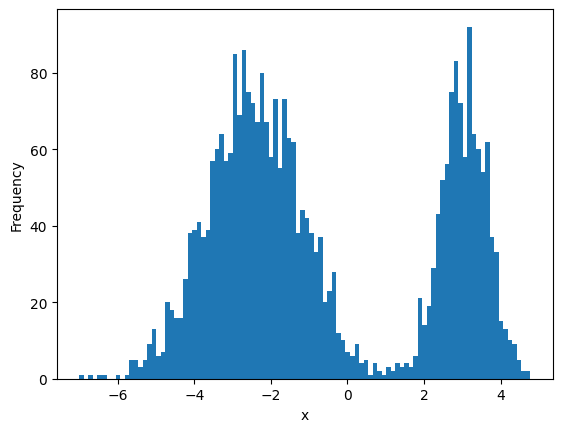

In [3]:
import numpy as np
import torch
import zuko
import matplotlib.pyplot as plt
import time

## Generate data (roughly in the range [-10,10])
def dgp(size=300):
    gaussian_data = np.random.normal(loc=-4, scale=2, size=int(size*2/3))
    exponential_data = np.random.normal(loc=5, scale=1, size=int(size/3))
    complex_data = np.concatenate((gaussian_data, exponential_data))
    complex_data = complex_data * 7 / np.max(np.abs(complex_data))
    np.random.shuffle(complex_data)
    return torch.tensor(complex_data, dtype=torch.float32).view(-1, 1)

d = dgp(3000);
plt.hist(d.numpy(), bins=100);
plt.xlabel('x');
plt.ylabel('Frequency');

zuko.__version__


#### Definition of the flows

From https://github.com/probabilists/zuko/edit/bernstein/README.md

| Class   | Year | Reference |
|:-------:|:----:|-----------|
| `GMM`   | -    | [Gaussian Mixture Model](https://wikipedia.org/wiki/Mixture_model#Gaussian_mixture_model) |
| `NICE`  | 2014 | [Non-linear Independent Components Estimation](https://arxiv.org/abs/1410.8516) |
| `MAF`   | 2017 | [Masked Autoregressive Flow for Density Estimation](https://arxiv.org/abs/1705.07057) |
| `NSF`   | 2019 | [Neural Spline Flows](https://arxiv.org/abs/1906.04032) |
| `NCSF`  | 2020 | [Normalizing Flows on Tori and Spheres](https://arxiv.org/abs/2002.02428) |
| `SOSPF` | 2019 | [Sum-of-Squares Polynomial Flow](https://arxiv.org/abs/1905.02325) |
| `NAF`   | 2018 | [Neural Autoregressive Flows](https://arxiv.org/abs/1804.00779) |
| `UNAF`  | 2019 | [Unconstrained Monotonic Neural Networks](https://arxiv.org/abs/1908.05164) |
| `CNF`   | 2018 | [Neural Ordinary Differential Equations](https://arxiv.org/abs/1806.07366) |
| `GF`    | 2020 | [Gaussianization Flows](https://arxiv.org/abs/2003.01941) |
| `BPF`   | 2020 | [Deep Transformation Models: ...](https://arxiv.org/abs/2004.00464) |

In [4]:
y = dgp()
context = 1 # New in 1.1.0 context is not needed anymore
hidden_features = [128] * 10 
x = torch.ones_like(y) # does not work w/o context (also for NSF) using dummy variable
flows = [
    zuko.flows.SOSPF(features=1, context=context, transforms=1, hidden_features=hidden_features),
    zuko.flows.NSF(features=1, context=context, transforms=1, hidden_features=hidden_features),
    zuko.flows.BPF(features=1, context=context, transforms=1, hidden_features=hidden_features, degree=30), 
    zuko.flows.GMM(features=1, context=context,  hidden_features=hidden_features), # Should be the best since DGP is a mixture of Gaussians
    #zuko.flows.NICE(features=1, context=context, transforms=1, hidden_features=hidden_features), #Bad performance when not chaining
    zuko.flows.MAF(features=1, context=context, transforms=1, hidden_features=hidden_features),
    #zuko.flows.NCSF(features=1, context=context, transforms=1, hidden_features=[128] * 3), # On Torie and Spehers
    zuko.flows.NAF(features=1, context=context, transforms=1, hidden_features=hidden_features),
    #zuko.flows.UNAF(features=1, context=context, transforms=1, hidden_features=hidden_features), # Slow
    #zuko.flows.CNF(features=1, context=context,  hidden_features=[128] * 3), Takes about 200 seconds
    zuko.flows.GF(features=1, context=context, transforms=1, hidden_features=hidden_features),
]

### Training and plotting of loss curves

In [5]:
from tqdm import tqdm

epochs = 500
losses_train = []
losses_test = []
training_times = []

# Add a tqdm progress bar for the outer loop
for flow in tqdm(flows, desc="Flows"):
    #print(flow.__class__.__name__)
    optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)
    loss_history = np.zeros(epochs)
    loss_history_test = np.zeros(epochs)
    y_test = dgp(1000)  # Test data on more points
    x_test = torch.ones_like(y_test)
    start_time = time.time()
    
    # Add a tqdm progress bar for the inner loop
    for e in tqdm(range(epochs), desc="Epochs"):
        if (context == 0):    
            loss = -flow().log_prob(y).mean()  # -log p(y | x)
            NLL_test = -flow().log_prob(y_test).mean() 
        else:
            loss = -flow(x).log_prob(y).mean()
            NLL_test = -flow(x_test).log_prob(y_test).mean()

        loss_history_test[e] = (NLL_test.detach().numpy())
        loss_history[e] = (loss.detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    training_times.append(time.time() - start_time)  # Training time
    losses_train.append(loss_history)
    losses_test.append(loss_history_test)

# Rest of the code remains the same

Flows:   0%|          | 0/7 [00:00<?, ?it/s]

Flows: 100%|██████████| 7/7 [00:23<00:00,  3.37s/it]


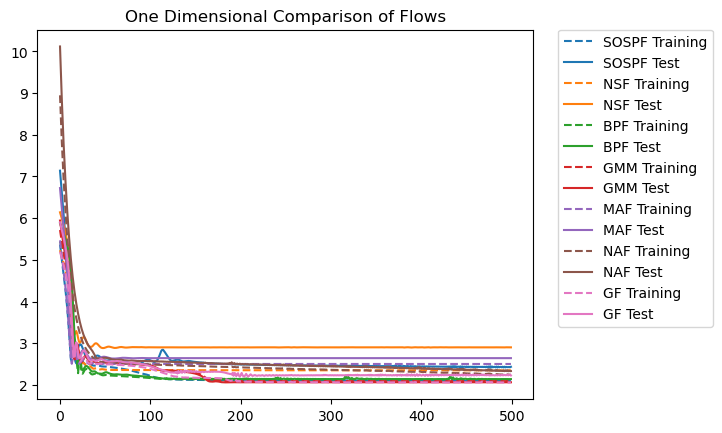

**Timeings done on a MAC M2**

,Flow,Training Time,Avg Training Loss (Last 15),Avg Test Loss (Last 15)
3,GMM,2.722598,2.089987,2.063171
2,BPF,3.602005,2.131451,2.139638
6,GF,2.757696,2.059854,2.235916
5,NAF,3.988532,2.249678,2.338761
0,SOSPF,2.820117,2.101115,2.429091
4,MAF,2.430801,2.502568,2.642452
1,NSF,3.116779,2.349542,2.901331


In [6]:
# Plot loss
plt.figure()
colors = plt.cm.tab10(np.arange(len(flows)))
for i, flow in enumerate(flows):
    loss_train = losses_train[i]
    loss_test = losses_test[i]
    plt.plot(loss_train, label=f"{flow.__class__.__name__} Training", color=colors[i], linestyle='--')
    plt.plot(loss_test, label=f"{flow.__class__.__name__} Test", color=colors[i], linestyle='-')
#Place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("One Dimensional Comparison of Flows")
plt.show()

# Calculate average losses for the last 15 epochs
avg_train_loss_last_15 = [np.mean(loss[-15:]) for loss in losses_train]
avg_test_loss_last_15 = [np.mean(loss[-15:]) for loss in losses_test]

# Create DataFrame with flow names, training times, and average losses
df = pd.DataFrame({
    "Flow": [flow.__class__.__name__ for flow in flows],
    "Training Time": training_times,
    "Avg Training Loss (Last 15)": avg_train_loss_last_15,
    "Avg Test Loss (Last 15)": avg_test_loss_last_15
})

# Display DataFrame
df
df_sorted = df.sort_values(by="Avg Test Loss (Last 15)")
from IPython.display import display, Markdown
display(Markdown("**Timeings done on a MAC M2**"))
display(df_sorted)


### Evaluation of the model


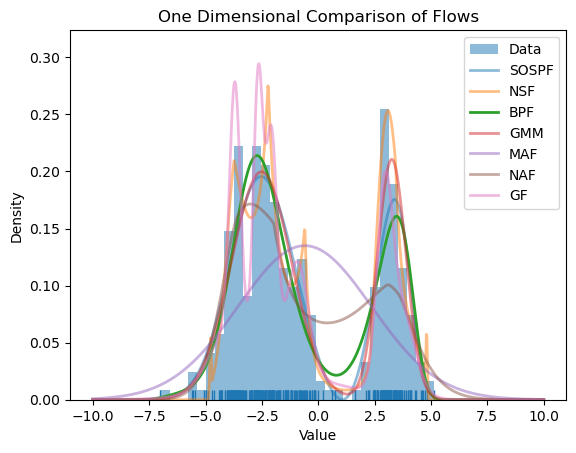

In [7]:
import seaborn as sns

# Plot histograms
plt.hist(y.numpy(), bins=30, density=True, label="Data", alpha=0.5)
sns.rugplot(y.numpy(), color="black")  # Add rug plot

plt.xlabel("Value")
plt.ylabel("Density")

# Adding the density form the flow
xx = torch.linspace(-10, 10, 1000)
for i, flow in enumerate(flows):
    if (context == 0):
        yy = flow().log_prob(xx[...,None]).exp().detach().numpy()
    else:
        yy = flow(x[:1]).log_prob(xx[...,None]).exp().detach().numpy()
    plt.plot(xx, yy, label=flow.__class__.__name__, color=colors[i], linewidth=2, 
             alpha = 1.0 if flow.__class__.__name__ == "BPF" else 0.5)


plt.title("One Dimensional Comparison of Flows")
plt.legend()
plt.show()